## Installation

In [1]:
!pip install transformers datasets evaluate spacy matplotlib -q
!python -m spacy download en_core_web_sm -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 97.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Mounting Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Imports

In [3]:
# ============================================================
# CS6120 Project: GAP + BERT + Rule-Based + CNN
# with Counterfactual Data Augmentation (CDA) and Bias Analysis
# + WinoBias Evaluation
# ============================================================

# NOTE:
# - This file assumes the following packages are installed:
#   transformers, datasets, evaluate, torch, spacy, matplotlib
# - In a notebook, you can install with:
#   !pip install transformers datasets evaluate spacy matplotlib
#   !python -m spacy download en_core_web_sm


import math
import random
from dataclasses import dataclass
from typing import List, Dict, Any, Optional, Tuple
import torch.nn as nn


import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from datasets import load_dataset
from transformers import BertTokenizerFast, BertForSequenceClassification
import evaluate
import spacy
import matplotlib.pyplot as plt





## Configuration settings

In [4]:



# ============================================================
# CONFIG
# ============================================================

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
RANDOM_SEED = 42
MAX_LEN_BERT = 256

# CNN CONFIG
GLOVE_PATH = "/content/drive/MyDrive/glove.6B.100d.txt"
MAX_LEN_CNN = 300
EMBED_DIM = 100
CNN_FILTER_SIZES = (3, 4, 5)
CNN_NUM_FILTERS = 100
CNN_DROPOUT = 0.5
CNN_LR = 1e-3
CNN_EPOCHS = 8
CNN_BATCH_SIZE = 32



# ============================================================
# SEEDING
# ============================================================

def set_seed(seed: int = RANDOM_SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


set_seed(RANDOM_SEED)



## Loading GAP dataset

In [5]:


# ============================================================
# LOAD GAP DATASET AND BUILD EXAMPLES
# ============================================================

def load_gap_splits():
    """
    Load GAP splits from HuggingFace.

    Returns:
        train_df, val_df, test_df as pandas DataFrames.
    """
    raw = load_dataset("coref-data/gap_raw")

    train_split = "train" if "train" in raw else "validation"
    val_split = "validation" if "validation" in raw else train_split
    test_split = "test" if "test" in raw else val_split

    train_df = raw[train_split].to_pandas()
    val_df = raw[val_split].to_pandas()
    test_df = raw[test_split].to_pandas()

    return train_df, val_df, test_df


def build_gap_examples(df: pd.DataFrame) -> List[Dict[str, Any]]:
    """
    Convert GAP dataframe to list of unified examples.

    Each example is a dict with:
        text: full text
        pron: pronoun string
        A: candidate A string
        B: candidate B string
        label: 0 (A) or 1 (B)
        pron_offset, A_offset, B_offset: character offsets
    We only keep rows where exactly one of A-coref or B-coref is true.
    """
    examples = []
    for _, row in df.iterrows():
        a_coref = bool(row["A-coref"])
        b_coref = bool(row["B-coref"])
        # XOR: keep only unambiguous rows
        if not (a_coref ^ b_coref):
            continue

        label = 0 if a_coref else 1
        ex = {
            "text": row["Text"],
            "pron": row["Pronoun"],
            "A": row["A"],
            "B": row["B"],
            "label": label,
            "pron_offset": int(row["Pronoun-offset"]),
            "A_offset": int(row["A-offset"]),
            "B_offset": int(row["B-offset"]),
        }
        examples.append(ex)
    return examples



In [6]:

# ============================================================
# COUNTERFACTUAL DATA AUGMENTATION (CDA)
# ============================================================

# Basic gender swap dictionary; you can extend this as needed.
GENDER_SWAP = {
    "he": "she",
    "she": "he",
    "him": "her",
    "her": "him",
    "his": "her",
    "hers": "his",
    "himself": "herself",
    "herself": "himself",
    "man": "woman",
    "woman": "man",
    "boy": "girl",
    "girl": "boy",
    "father": "mother",
    "mother": "father",
    "son": "daughter",
    "daughter": "son",
    "husband": "wife",
    "wife": "husband",
}


def swap_gender_word(token: str) -> str:
    """
    Swap a single token's gender if it's in the dictionary, attempting
    to preserve capitalization of the first character.
    """
    lower = token.lower()
    if lower not in GENDER_SWAP:
        return token

    swapped = GENDER_SWAP[lower]
    # Preserve capitalization pattern for first char
    if token[0].isupper():
        swapped = swapped.capitalize()
    return swapped


def swap_gender_in_text(text: str) -> str:
    """
    Very simple whitespace-based token swap.
    This is not linguistically perfect, but is sufficient for CDA here.
    """
    tokens = text.split()
    new_tokens = [swap_gender_word(tok) for tok in tokens]
    return " ".join(new_tokens)


def recompute_offset(text: str, substring: str) -> Optional[int]:
    """
    Try to find substring in text and return its (first) character offset.
    Returns None if not found.
    """
    if not substring:
        return None
    idx = text.lower().find(substring.lower())
    return idx if idx >= 0 else None


def apply_cda_to_example(ex: Dict[str, Any]) -> Optional[Dict[str, Any]]:
    """
    Given a single example, create a gender-swapped counterfactual example.
    If no gendered terms can be swapped, return None.
    """
    orig_text = ex["text"]
    orig_pron = ex["pron"]

    new_text = swap_gender_in_text(orig_text)
    new_pron = swap_gender_word(orig_pron)

    # If nothing changed, skip
    if new_text == orig_text and new_pron == orig_pron:
        return None

    # A and B we leave as names
    new_A = ex["A"]
    new_B = ex["B"]

    # Recompute offsets in the new text
    new_pron_offset = recompute_offset(new_text, new_pron)
    new_A_offset = recompute_offset(new_text, new_A)
    new_B_offset = recompute_offset(new_text, new_B)

    cf = {
        "text": new_text,
        "pron": new_pron,
        "A": new_A,
        "B": new_B,
        "label": ex["label"],
        "pron_offset": new_pron_offset,
        "A_offset": new_A_offset,
        "B_offset": new_B_offset,
    }
    return cf


def build_cda_augmented_dataset(examples: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """
    Take a list of examples and return:
        original + all valid counterfactual (gender-swapped) examples.
    """
    augmented = list(examples)
    num_cf = 0
    for ex in examples:
        cf = apply_cda_to_example(ex)
        if cf is not None:
            augmented.append(cf)
            num_cf += 1
    print(f"[CDA] Created {num_cf} counterfactual examples (total = {len(augmented)})")
    return augmented


## Dataset classes for models

In [7]:


# ============================================================
# DATASETS FOR BERT AND CNN
# ============================================================

class BertGapDataset(Dataset):
    """
    PyTorch Dataset for BERT-based GAP classification.
    Takes unified examples and encodes (text, choices) pair.
    """

    def __init__(self, examples: List[Dict[str, Any]], tokenizer: BertTokenizerFast, max_length: int = MAX_LEN_BERT):
        self.examples = examples
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        ex = self.examples[idx]

        text = ex["text"]
        pron = ex["pron"]
        A = ex["A"]
        B = ex["B"]
        label = ex["label"]

        choice_text = f"Pronoun: {pron} [SEP] A: {A} [SEP] B: {B}"

        enc = self.tokenizer(
            text,
            choice_text,
            truncation=True,
            max_length=self.max_length,
            padding="max_length",
            return_tensors="pt",
        )
        enc = {k: v.squeeze(0) for k, v in enc.items()}
        enc["labels"] = torch.tensor(label, dtype=torch.long)
        return enc

class CnnGapDataset(Dataset):
    """
    PyTorch Dataset for CNN+GloVe-based GAP classification.
    Takes unified examples and encodes a single combined text sequence.
    """

    def __init__(self, examples, tokenizer_fn, max_length: int = MAX_LEN_CNN):
        self.examples = examples
        self.tokenizer_fn = tokenizer_fn  # function: text -> list of token ids
        self.max_length = max_length

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        ex = self.examples[idx]

        text = ex["text"]
        pron = ex["pron"]
        A = ex["A"]
        B = ex["B"]
        label = ex["label"]

        # Combine into one sequence (similar semantics to BERT pair)
        combined = f"{text} Pronoun: {pron} A: {A} B: {B}"

        token_ids = self.tokenizer_fn(combined)

        # Pad / truncate
        if len(token_ids) < self.max_length:
            token_ids = token_ids + [0] * (self.max_length - len(token_ids))
        else:
            token_ids = token_ids[:self.max_length]

        input_ids = torch.tensor(token_ids, dtype=torch.long)
        labels = torch.tensor(label, dtype=torch.long)
        return {"input_ids": input_ids, "labels": labels}



## Model classes

In [8]:

# ============================================================
# MODEL INTERFACES
# ============================================================

class BaseCorefModel:
    """Minimal interface for all coref models."""

    def fit(self, train_examples: List[Dict[str, Any]]):
        raise NotImplementedError

    def predict_batch(self, examples: List[Dict[str, Any]]) -> List[int]:
        """Return list of 0/1 predictions for the batch of examples."""
        raise NotImplementedError


# ============================================================
# BERT MODEL WRAPPER
# ============================================================

class BertCorefModel(BaseCorefModel):
    def __init__(
        self,
        model_name: str = "bert-base-uncased",
        lr: float = 3e-5,
        epochs: int = 4,
        batch_size: int = 8,
        max_length: int = MAX_LEN_BERT,
    ):
        self.model_name = model_name
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.max_length = max_length

        self.tokenizer = BertTokenizerFast.from_pretrained(self.model_name)
        self.model = BertForSequenceClassification.from_pretrained(
            self.model_name, num_labels=2
        ).to(DEVICE)

    def fit(self, train_examples: List[Dict[str, Any]]):
        dataset = BertGapDataset(train_examples, self.tokenizer, self.max_length)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        optimizer = AdamW(self.model.parameters(), lr=self.lr)

        self.model.train()
        for epoch in range(self.epochs):
            total_loss = 0.0
            for batch in loader:
                batch = {k: v.to(DEVICE) for k, v in batch.items()}
                outputs = self.model(**batch)
                loss = outputs.loss

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                total_loss += loss.item()

            avg_loss = total_loss / max(1, len(loader))
            print(f"[BERT] Epoch {epoch + 1}/{self.epochs} - Loss: {avg_loss:.4f}")

    def _predict_logits(self, examples: List[Dict[str, Any]]) -> np.ndarray:
        dataset = BertGapDataset(examples, self.tokenizer, self.max_length)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)

        self.model.eval()
        all_logits = []
        with torch.no_grad():
            for batch in loader:
                labels = batch["labels"]  # not used
                batch = {k: v.to(DEVICE) for k, v in batch.items()}
                logits = self.model(**batch).logits
                all_logits.append(logits.cpu().numpy())
        return np.concatenate(all_logits, axis=0)

    def predict_batch(self, examples: List[Dict[str, Any]]) -> List[int]:
        logits = self._predict_logits(examples)
        preds = logits.argmax(axis=-1)
        return preds.tolist()


# ============================================================
# RULE-BASED CLASSIFIER
# ============================================================

# Load spaCy model
try:
    nlp = spacy.load("en_core_web_sm")
except Exception:
    print("spaCy model 'en_core_web_sm' not found. Please install it with:")
    print("  python -m spacy download en_core_web_sm")
    raise


class RuleBasedCoreferenceClassifier:
    """
    A rule-based classifier for coreference resolution using heuristics.
    """

    def __init__(self):
        # Gender mappings for pronouns and common names/titles
        self.male_pronouns = {'he', 'him', 'his', 'himself'}
        self.female_pronouns = {'she', 'her', 'hers', 'herself'}
        self.neutral_pronouns = {'they', 'them', 'their', 'theirs', 'themselves', 'it', 'its', 'itself'}

        self.male_indicators = {
            'mr', 'mr.', 'mister', 'sir', 'lord', 'king', 'prince', 'duke',
            'father', 'dad', 'son', 'brother', 'uncle', 'nephew', 'husband',
            'boy', 'man', 'male', 'gentleman', 'guy'
        }

        self.female_indicators = {
            'ms', 'ms.', 'mrs', 'mrs.', 'miss', 'lady', 'queen', 'princess', 'duchess',
            'mother', 'mom', 'daughter', 'sister', 'aunt', 'niece', 'wife',
            'girl', 'woman', 'female', 'lady', 'gal'
        }

        self.male_names = {
            'john', 'michael', 'david', 'james', 'robert', 'william', 'richard',
            'thomas', 'charles', 'daniel', 'matthew', 'anthony', 'mark', 'donald',
            'steven', 'kenneth', 'andrew', 'kevin', 'brian', 'george'
        }

        self.female_names = {
            'mary', 'patricia', 'jennifer', 'linda', 'elizabeth', 'barbara',
            'susan', 'jessica', 'sarah', 'karen', 'nancy', 'betty', 'helen',
            'sandra', 'donna', 'carol', 'ruth', 'sharon', 'michelle', 'laura'
        }

    def infer_gender(self, text, name):
        name_lower = name.lower()
        text_lower = text.lower()

        first_name = name_lower.split()[0] if name_lower.split() else name_lower
        if first_name in self.male_names:
            return 'male'
        if first_name in self.female_names:
            return 'female'

        window = 50
        name_pos = text_lower.find(name_lower)
        if name_pos != -1:
            context_start = max(0, name_pos - window)
            context_end = min(len(text_lower), name_pos + len(name_lower) + window)
            context = text_lower[context_start:context_end]
            context_words = set(context.split())
            if context_words & self.male_indicators:
                return 'male'
            if context_words & self.female_indicators:
                return 'female'

        return 'unknown'

    def get_pronoun_gender(self, pronoun):
        pronoun_lower = pronoun.lower()
        if pronoun_lower in self.male_pronouns:
            return 'male'
        elif pronoun_lower in self.female_pronouns:
            return 'female'
        else:
            return 'neutral'

    def calculate_distance(self, text, pos1, pos2):
        if pos1 is None or pos2 is None:
            return 9999.0
        return abs(pos1 - pos2) / 5.0

    def is_subject(self, text, entity_text, entity_pos):
        doc = nlp(text)
        for token in doc:
            if token.text == entity_text or entity_text in token.text:
                if token.dep_ in ['nsubj', 'nsubjpass']:
                    return True
        return False

    def same_sentence(self, text, pos1, pos2):
        if pos1 is None or pos2 is None:
            return False
        start = min(pos1, pos2)
        end = max(pos1, pos2)
        segment = text[start:end]
        sentence_ends = segment.count('.') + segment.count('!') + segment.count('?')
        return sentence_ends == 0

    def predict(self, text, pronoun, pronoun_offset, a_text, a_offset, b_text, b_offset):
        pronoun_gender = self.get_pronoun_gender(pronoun)

        a_gender = self.infer_gender(text, a_text)
        b_gender = self.infer_gender(text, b_text)

        a_score = 0
        b_score = 0

        if pronoun_gender != 'neutral':
            if a_gender == pronoun_gender:
                a_score += 10
            elif a_gender != 'unknown' and a_gender != pronoun_gender:
                a_score -= 10

            if b_gender == pronoun_gender:
                b_score += 10
            elif b_gender != 'unknown' and b_gender != pronoun_gender:
                b_score -= 10

        a_distance = self.calculate_distance(text, pronoun_offset, a_offset)
        b_distance = self.calculate_distance(text, pronoun_offset, b_offset)

        if a_distance < b_distance:
            a_score += 5
        else:
            b_score += 5

        if a_offset is not None and b_offset is not None and pronoun_offset is not None:
            if a_offset < pronoun_offset and b_offset > pronoun_offset:
                a_score += 3
            elif b_offset < pronoun_offset and a_offset > pronoun_offset:
                b_score += 3

        if self.same_sentence(text, pronoun_offset, a_offset):
            a_score += 2
        if self.same_sentence(text, pronoun_offset, b_offset):
            b_score += 2

        if self.is_subject(text, a_text, a_offset):
            a_score += 3
        if self.is_subject(text, b_text, b_offset):
            b_score += 3

        if a_offset is not None and pronoun_offset is not None and a_offset > pronoun_offset:
            a_score -= 2
        if b_offset is not None and pronoun_offset is not None and b_offset > pronoun_offset:
            b_score -= 2

        if a_score > b_score:
            return 0
        elif b_score > a_score:
            return 1
        else:
            if a_distance <= b_distance:
                return 0
            else:
                return 1


class RuleBasedCorefWrapper(BaseCorefModel):
    """Adapter to fit the BaseCorefModel interface."""

    def __init__(self):
        self.clf = RuleBasedCoreferenceClassifier()

    def fit(self, train_examples: List[Dict[str, Any]]):
        return

    def predict_batch(self, examples: List[Dict[str, Any]]) -> List[int]:
        preds = []
        for ex in examples:
            pred = self.clf.predict(
                text=ex["text"],
                pronoun=ex["pron"],
                pronoun_offset=ex.get("pron_offset"),
                a_text=ex["A"],
                a_offset=ex.get("A_offset"),
                b_text=ex["B"],
                b_offset=ex.get("B_offset"),
            )
            preds.append(pred)
        return preds


# ============================================================
# CNN + GLOVE
# ============================================================

class CnnTextClassifier(nn.Module):
    def __init__(
        self,
        num_embeddings: int,
        embedding_dim: int,
        embedding_matrix: np.ndarray,
        num_classes: int = 2,
        filter_sizes: Tuple[int, ...] = CNN_FILTER_SIZES,
        num_filters: int = CNN_NUM_FILTERS,
        dropout: float = CNN_DROPOUT,
        freeze_embeddings: bool = True,
    ):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        if freeze_embeddings:
            self.embedding.weight.requires_grad = False

        self.convs = nn.ModuleList([
            nn.Conv1d(
                in_channels=embedding_dim,
                out_channels=num_filters,
                kernel_size=fs
            )
            for fs in filter_sizes
        ])

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_filters * len(filter_sizes), num_classes)

    def forward(self, input_ids):
        # input_ids: [batch, seq_len]
        x = self.embedding(input_ids)            # [batch, seq_len, emb_dim]
        x = x.transpose(1, 2)                    # [batch, emb_dim, seq_len]

        conv_outputs = []
        for conv in self.convs:
            c = conv(x)                          # [batch, num_filters, L']
            c = torch.relu(c)
            pooled = torch.max(c, dim=2).values  # [batch, num_filters]
            conv_outputs.append(pooled)

        cat = torch.cat(conv_outputs, dim=1)     # [batch, num_filters * len(filter_sizes)]
        cat = self.dropout(cat)
        logits = self.fc(cat)                    # [batch, num_classes]
        return logits


class CnnGloveCorefModel(BaseCorefModel):
    """
    CNN + GloVe coref model that matches the BaseCorefModel interface.
    Uses glove.6B.100d embeddings and a Kim-style CNN.
    """

    def __init__(
        self,
        glove_path: str = GLOVE_PATH,
        max_length: int = MAX_LEN_CNN,
        lr: float = CNN_LR,
        epochs: int = CNN_EPOCHS,
        batch_size: int = CNN_BATCH_SIZE,
        filter_sizes: Tuple[int, ...] = CNN_FILTER_SIZES,
        num_filters: int = CNN_NUM_FILTERS,
        dropout: float = CNN_DROPOUT,
        freeze_embeddings: bool = True,
    ):
        self.glove_path = glove_path
        self.max_length = max_length
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.filter_sizes = filter_sizes
        self.num_filters = num_filters
        self.dropout = dropout
        self.freeze_embeddings = freeze_embeddings

        # These will be set in fit()
        self.word2idx: Dict[str, int] = {}
        self.idx2word: List[str] = []
        self.model: Optional[nn.Module] = None

        # Special tokens
        self.PAD_TOKEN = "<PAD>"
        self.UNK_TOKEN = "<UNK>"



    # -----------------------------
    # Vocabulary & GloVe utilities
    # -----------------------------
    def _basic_tokenize(self, text: str) -> List[str]:
        # lowercased whitespace tokenization to match GloVe 6B lowercase vocab
        return text.lower().split()

    def _build_vocab(self, examples: List[Dict[str, Any]]):
        vocab = {self.PAD_TOKEN, self.UNK_TOKEN}
        for ex in examples:
            text = ex["text"]
            pron = ex["pron"]
            A = ex["A"]
            B = ex["B"]
            combined = f"{text} Pronoun: {pron} A: {A} B: {B}"
            tokens = self._basic_tokenize(combined)
            vocab.update(tokens)

        vocab = sorted(list(vocab))
        self.word2idx = {w: i for i, w in enumerate(vocab)}
        self.idx2word = vocab

    def _load_glove_embeddings(self) -> np.ndarray:
        print(f"[CNN] Loading GloVe embeddings from {self.glove_path} ...")
        glove = {}
        with open(self.glove_path, "r", encoding="utf8") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < EMBED_DIM + 1:
                    continue
                word = parts[0]
                vec = np.asarray(parts[1:], dtype="float32")
                glove[word] = vec

        vocab_size = len(self.word2idx)
        embedding_matrix = np.random.normal(scale=0.1, size=(vocab_size, EMBED_DIM)).astype("float32")

        num_found = 0
        for word, idx in self.word2idx.items():
            if word in glove:
                embedding_matrix[idx] = glove[word]
                num_found += 1

        print(f"[CNN] Built embedding matrix: vocab_size={vocab_size}, found_in_glove={num_found}")
        return embedding_matrix

    def _text_to_ids(self, text: str) -> List[int]:
        tokens = self._basic_tokenize(text)
        ids = [self.word2idx.get(tok, self.word2idx[self.UNK_TOKEN]) for tok in tokens]
        return ids

    # -----------------------------
    # BaseCorefModel methods
    # -----------------------------
    def fit(self, train_examples: List[Dict[str, Any]]):


        # Build vocab from training data
        print("[CNN] Building vocabulary...")
        self._build_vocab(train_examples)

        # Load embeddings
        embedding_matrix = self._load_glove_embeddings()

        # Build model
        vocab_size = len(self.word2idx)
        self.model = CnnTextClassifier(
            num_embeddings=vocab_size,
            embedding_dim=EMBED_DIM,
            embedding_matrix=embedding_matrix,
            num_classes=2,
            filter_sizes=self.filter_sizes,
            num_filters=self.num_filters,
            dropout=self.dropout,
            freeze_embeddings=self.freeze_embeddings,
        ).to(DEVICE)

        # Create dataset + dataloader
        def tokenizer_fn(text: str) -> List[int]:
            return self._text_to_ids(text)

        dataset = CnnGapDataset(train_examples, tokenizer_fn, max_length=self.max_length)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        criterion = nn.CrossEntropyLoss()
        optimizer = AdamW(filter(lambda p: p.requires_grad, self.model.parameters()), lr=self.lr)

        print("[CNN] Starting training...")
        self.model.train()
        for epoch in range(self.epochs):
            total_loss = 0.0
            for batch in loader:
                input_ids = batch["input_ids"].to(DEVICE)
                labels = batch["labels"].to(DEVICE)

                optimizer.zero_grad()
                logits = self.model(input_ids)
                loss = criterion(logits, labels)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            avg_loss = total_loss / max(1, len(loader))
            print(f"[CNN] Epoch {epoch + 1}/{self.epochs} - Loss: {avg_loss:.4f}")

        print("[CNN] Training completed.")

    def _predict_logits(self, examples: List[Dict[str, Any]]) -> np.ndarray:
        if self.model is None:
            raise RuntimeError("CNN model has not been trained. Call fit() first.")

        def tokenizer_fn(text: str) -> List[int]:
            return self._text_to_ids(text)

        dataset = CnnGapDataset(examples, tokenizer_fn, max_length=self.max_length)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)

        self.model.eval()
        all_logits = []
        with torch.no_grad():
            for batch in loader:
                input_ids = batch["input_ids"].to(DEVICE)
                logits = self.model(input_ids)
                all_logits.append(logits.cpu().numpy())

        return np.concatenate(all_logits, axis=0)

    def predict_batch(self, examples: List[Dict[str, Any]]) -> List[int]:
        if not examples:
            return []
        logits = self._predict_logits(examples)
        preds = logits.argmax(axis=-1)
        return preds.tolist()




## Evaluation utilities

In [9]:

# ============================================================
# EVALUATION UTILITIES (ACCURACY, F1, GENDER BIAS)
# ============================================================

acc_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

MALE_PRONOUNS = {"he", "him", "his", "himself"}
FEMALE_PRONOUNS = {"she", "her", "hers", "herself"}


@dataclass
class EvalResult:
    model_name: str
    variant: str
    eval_set: str
    train_data: str
    val_acc: float
    val_f1: float
    male_acc: float
    female_acc: float
    bias_pct: float


def evaluate_model(
    model: BaseCorefModel,
    examples: List[Dict[str, Any]]
) -> Tuple[float, float]:
    preds = model.predict_batch(examples)
    labels = [ex["label"] for ex in examples]

    acc = acc_metric.compute(predictions=preds, references=labels)["accuracy"]
    f1 = f1_metric.compute(predictions=preds, references=labels)["f1"]
    return acc, f1


def compute_gender_bias(
    model: BaseCorefModel,
    examples: List[Dict[str, Any]]
) -> Tuple[float, float, float]:
    male_preds, male_labels = [], []
    fem_preds, fem_labels = [], []

    for ex in examples:
        pron = ex["pron"].lower()
        pred = model.predict_batch([ex])[0]
        lab = ex["label"]

        if pron in MALE_PRONOUNS:
            male_preds.append(pred)
            male_labels.append(lab)
        elif pron in FEMALE_PRONOUNS:
            fem_preds.append(pred)
            fem_labels.append(lab)

    if male_labels:
        male_acc = acc_metric.compute(predictions=male_preds, references=male_labels)["accuracy"]
    else:
        male_acc = 0.0

    if fem_labels:
        fem_acc = acc_metric.compute(predictions=fem_preds, references=fem_labels)["accuracy"]
    else:
        fem_acc = 0.0

    bias_pct = (male_acc - fem_acc) * 100.0
    return male_acc, fem_acc, bias_pct


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## WEAT test

In [10]:


# ============================================================
# WEAT (WORD EMBEDDING ASSOCIATION TEST) FOR BERT
# ============================================================

def get_bert_cls_embedding(tokenizer: BertTokenizerFast, model: BertForSequenceClassification, word: str) -> np.ndarray:
    enc = tokenizer(word, return_tensors="pt", truncation=True).to(DEVICE)
    with torch.no_grad():
        out = model.bert(**enc).last_hidden_state
    return out[0, 0].cpu().numpy()


def cos_sim(a: np.ndarray, b: np.ndarray) -> float:
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))


def association(w_vec: np.ndarray, A_vecs: List[np.ndarray], B_vecs: List[np.ndarray]) -> float:
    return np.mean([cos_sim(w_vec, a) for a in A_vecs]) - np.mean([cos_sim(w_vec, b) for b in B_vecs])


def run_weat_for_bert(
    tokenizer: BertTokenizerFast,
    model: BertForSequenceClassification,
    A_words: List[str],
    B_words: List[str],
    X_words: List[str],
    Y_words: List[str],
    perms: int = 400
) -> Tuple[float, float, float]:

    def get_vecs(words: List[str]) -> List[np.ndarray]:
        vecs = []
        for w in words:
            try:
                vecs.append(get_bert_cls_embedding(tokenizer, model, w))
            except Exception:
                pass
        return vecs

    A_vecs = get_vecs(A_words)
    B_vecs = get_vecs(B_words)
    X_vecs = get_vecs(X_words)
    Y_vecs = get_vecs(Y_words)

    sX = [association(w, A_vecs, B_vecs) for w in X_vecs]
    sY = [association(w, A_vecs, B_vecs) for w in Y_vecs]

    S_obs = float(np.sum(sX) - np.sum(sY))
    effect = (np.mean(sX) - np.mean(sY)) / np.std(sX + sY)

    Z = X_vecs + Y_vecs
    nX = len(X_vecs)
    if nX == 0 or len(Z) == 0:
        return S_obs, effect, 1.0

    perm_stats = []
    for _ in range(perms):
        np.random.shuffle(Z)
        Xp = Z[:nX]
        Yp = Z[nX:]
        sXp = [association(w, A_vecs, B_vecs) for w in Xp]
        sYp = [association(w, A_vecs, B_vecs) for w in Yp]
        perm_stats.append(np.sum(sXp) - np.sum(sYp))

    perm_stats = np.array(perm_stats)
    p_val = (np.sum(perm_stats >= S_obs) + 1) / (len(perm_stats) + 1)

    return S_obs, float(effect), float(p_val)

def run_weat_for_cnn_glove(
    cnn_model: CnnGloveCorefModel,
    A_words: List[str],
    B_words: List[str],
    X_words: List[str],
    Y_words: List[str],
    perms: int = 400
) -> Tuple[float, float, float]:
    """
    WEAT for CNN+GloVe:
    Uses the CNN model's embedding layer (which is initialized from GloVe)
    to extract word embeddings and then runs the same WEAT computation as for BERT.
    """

    if cnn_model.model is None:
        raise RuntimeError("CNN model has not been trained. Call fit() before WEAT.")

    emb_weight = cnn_model.model.embedding.weight  # [vocab_size, EMBED_DIM]

    def get_vecs(words: List[str]) -> List[np.ndarray]:
        vecs = []
        for w in words:
            w_lower = w.lower()
            if w_lower in cnn_model.word2idx:
                idx = cnn_model.word2idx[w_lower]
                vec = emb_weight[idx].detach().cpu().numpy()
                vecs.append(vec)
        return vecs

    A_vecs = get_vecs(A_words)
    B_vecs = get_vecs(B_words)
    X_vecs = get_vecs(X_words)
    Y_vecs = get_vecs(Y_words)

    # If we somehow have no usable vectors, bail out gracefully
    if len(A_vecs) == 0 or len(B_vecs) == 0 or len(X_vecs) == 0 or len(Y_vecs) == 0:
        return 0.0, 0.0, 1.0

    sX = [association(w, A_vecs, B_vecs) for w in X_vecs]
    sY = [association(w, A_vecs, B_vecs) for w in Y_vecs]

    S_obs = float(np.sum(sX) - np.sum(sY))
    effect = (np.mean(sX) - np.mean(sY)) / np.std(sX + sY)

    Z = X_vecs + Y_vecs
    nX = len(X_vecs)
    if nX == 0 or len(Z) == 0:
        return S_obs, float(effect), 1.0

    perm_stats = []
    for _ in range(perms):
        np.random.shuffle(Z)
        Xp = Z[:nX]
        Yp = Z[nX:]
        sXp = [association(w, A_vecs, B_vecs) for w in Xp]
        sYp = [association(w, A_vecs, B_vecs) for w in Yp]
        perm_stats.append(np.sum(sXp) - np.sum(sYp))

    perm_stats = np.array(perm_stats)
    p_val = (np.sum(perm_stats >= S_obs) + 1) / (len(perm_stats) + 1)

    return S_obs, float(effect), float(p_val)



## Visualization Code

In [11]:

# ============================================================
# PLOTTING / VISUALIZATION
# ============================================================

def plot_validation_accuracy(results: List[EvalResult]):
    filtered = [r for r in results if r.eval_set == "val_orig"]

    labels = [f"{r.model_name}-{r.variant}" for r in filtered]
    values = [r.val_acc for r in filtered]

    plt.figure(figsize=(8, 5))
    plt.bar(range(len(values)), values)
    plt.xticks(range(len(values)), labels, rotation=45, ha="right")
    plt.ylabel("Validation Accuracy")
    plt.title("Validation Accuracy on Original GAP (by Model/Variant)")
    plt.tight_layout()
    plt.show()


def plot_gender_bias(results: List[EvalResult]):
    filtered = [r for r in results if r.eval_set == "val_orig"]

    labels = [f"{r.model_name}-{r.variant}" for r in filtered]
    male_vals = [r.male_acc for r in filtered]
    fem_vals = [r.female_acc for r in filtered]

    x = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=(8, 5))
    plt.bar(x - width / 2, male_vals, width, label="Male pronouns")
    plt.bar(x + width / 2, fem_vals, width, label="Female pronouns")

    plt.xticks(x, labels, rotation=45, ha="right")
    plt.ylabel("Accuracy")
    plt.title("Gender-Specific Accuracy on Original GAP (Validation)")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_validation_accuracy_cda(results: List[EvalResult]):
    """
    Bar chart of validation accuracy on the CDA-transformed GAP set.
    """
    filtered = [r for r in results if r.eval_set == "val_cda"]
    if not filtered:
        print("No CDA validation results to plot.")
        return

    labels = [f"{r.model_name}-{r.variant}" for r in filtered]
    values = [r.val_acc for r in filtered]

    plt.figure(figsize=(8, 5))
    plt.bar(range(len(values)), values)
    plt.xticks(range(len(values)), labels, rotation=45, ha="right")
    plt.ylabel("Validation Accuracy")
    plt.title("Validation Accuracy on CDA Validation Set (by Model/Variant)")
    plt.tight_layout()
    plt.show()


def plot_gender_bias_cda(results: List[EvalResult]):
    """
    Bar chart of male vs female accuracy on the CDA-transformed GAP set.
    """
    filtered = [r for r in results if r.eval_set == "val_cda"]
    if not filtered:
        print("No CDA validation results to plot.")
        return

    labels = [f"{r.model_name}-{r.variant}" for r in filtered]
    male_vals = [r.male_acc for r in filtered]
    fem_vals = [r.female_acc for r in filtered]

    x = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=(8, 5))
    plt.bar(x - width / 2, male_vals, width, label="Male pronouns")
    plt.bar(x + width / 2, fem_vals, width, label="Female pronouns")

    plt.xticks(x, labels, rotation=45, ha="right")
    plt.ylabel("Accuracy")
    plt.title("Gender-Specific Accuracy on CDA Validation Set")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_bias_orig_vs_cda(results: List[EvalResult]):
    """
    Compare Bias% on original vs CDA validation sets for each model/variant.
    """
    # Group results by (model_name, variant)
    grouped = {}
    for r in results:
        key = (r.model_name, r.variant)
        grouped.setdefault(key, {})[r.eval_set] = r

    # Keep only entries where we actually have both eval sets
    keys = [k for k, v in grouped.items() if "val_orig" in v and "val_cda" in v]
    if not keys:
        print("No models with both val_orig and val_cda results to compare.")
        return

    labels = [f"{m}-{v}" for (m, v) in keys]
    bias_orig = [grouped[k]["val_orig"].bias_pct for k in keys]
    bias_cda  = [grouped[k]["val_cda"].bias_pct  for k in keys]

    x = np.arange(len(keys))
    width = 0.35

    plt.figure(figsize=(9, 5))
    plt.bar(x - width / 2, bias_orig, width, label="Orig val")
    plt.bar(x + width / 2, bias_cda,  width, label="CDA val")

    plt.xticks(x, labels, rotation=45, ha="right")
    plt.ylabel("Bias% (Male - Female)")
    plt.title("Gender Bias on Original vs CDA Validation (by Model/Variant)")
    plt.axhline(0.0, linestyle="--", linewidth=1)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_accuracy_orig_vs_cda(results: List[EvalResult]):
    """
    Compare validation accuracy on original vs CDA validation sets.
    """
    grouped = {}
    for r in results:
        key = (r.model_name, r.variant)
        grouped.setdefault(key, {})[r.eval_set] = r

    keys = [k for k, v in grouped.items() if "val_orig" in v and "val_cda" in v]
    if not keys:
        print("No models with both val_orig and val_cda results to compare.")
        return

    labels = [f"{m}-{v}" for (m, v) in keys]
    acc_orig = [grouped[k]["val_orig"].val_acc for k in keys]
    acc_cda  = [grouped[k]["val_cda"].val_acc  for k in keys]

    x = np.arange(len(keys))
    width = 0.35

    plt.figure(figsize=(9, 5))
    plt.bar(x - width / 2, acc_orig, width, label="Orig val")
    plt.bar(x + width / 2, acc_cda,  width, label="CDA val")

    plt.xticks(x, labels, rotation=45, ha="right")
    plt.ylabel("Validation Accuracy")
    plt.title("Accuracy on Original vs CDA Validation (by Model/Variant)")
    plt.legend()
    plt.tight_layout()
    plt.show()




## Driver code

In [12]:


# ============================================================
# MAIN EXPERIMENT RUNNER (GAP + CDA + BERT + RULE-BASED)
# ============================================================

def main():
    global rb_model, bert_base, bert_cda, results, train_orig, val_orig, test_orig, val_cda, test_cda

    print("=" * 70)
    print("Loading GAP dataset...")
    train_df, val_df, test_df = load_gap_splits()

    print("Building GAP examples (original)...")
    train_orig = build_gap_examples(train_df)
    val_orig = build_gap_examples(val_df)
    test_orig = build_gap_examples(test_df)

    print(f"Train examples: {len(train_orig)} | Val: {len(val_orig)} | Test: {len(test_orig)}")

    print("Applying CDA to training set...")
    train_cda = build_cda_augmented_dataset(train_orig)

    print("Building CDA variants of validation and test sets for evaluation...")
    val_cda = []
    for ex in val_orig:
        cf = apply_cda_to_example(ex)
        if cf is not None:
            val_cda.append(cf)

    test_cda = []
    for ex in test_orig:
        cf = apply_cda_to_example(ex)
        if cf is not None:
            test_cda.append(cf)

    print(f"Val CDA examples: {len(val_cda)} | Test CDA: {len(test_cda)}")

    results = []

    # --------------------------------------------------------
    # RULE-BASED
    # --------------------------------------------------------
    print("\n" + "=" * 70)
    print("Evaluating Rule-Based Classifier")
    print("=" * 70)
    rb_model = RuleBasedCorefWrapper()

    val_acc, val_f1 = evaluate_model(rb_model, val_orig)
    male_acc, female_acc, bias = compute_gender_bias(rb_model, val_orig)
    print(f"[Rule-Based] Val (orig) - Acc: {val_acc:.4f}, F1: {val_f1:.4f}, "
          f"Male: {male_acc:.4f}, Female: {female_acc:.4f}, Bias%: {bias:+.2f}")

    results.append(EvalResult(
        model_name="RuleBased",
        variant="baseline",
        eval_set="val_orig",
        train_data="n/a",
        val_acc=val_acc,
        val_f1=val_f1,
        male_acc=male_acc,
        female_acc=female_acc,
        bias_pct=bias,
    ))

    if val_cda:
        val_cda_acc, val_cda_f1 = evaluate_model(rb_model, val_cda)
        male_acc_cda, female_acc_cda, bias_cda = compute_gender_bias(rb_model, val_cda)
        print(f"[Rule-Based] Val (CDA)  - Acc: {val_cda_acc:.4f}, F1: {val_cda_f1:.4f}, "
              f"Male: {male_acc_cda:.4f}, Female: {female_acc_cda:.4f}, Bias%: {bias_cda:+.2f}")

        results.append(EvalResult(
            model_name="RuleBased",
            variant="baseline",
            eval_set="val_cda",
            train_data="n/a",
            val_acc=val_cda_acc,
            val_f1=val_cda_f1,
            male_acc=male_acc_cda,
            female_acc=female_acc_cda,
            bias_pct=bias_cda,
        ))

    # --------------------------------------------------------
    # BERT BASELINE (TRAIN ON ORIGINAL)
    # --------------------------------------------------------
    print("\n" + "=" * 70)
    print("Training BERT Baseline (train on original GAP)")
    print("=" * 70)
    bert_base = BertCorefModel(lr=3e-5, epochs=4, batch_size=8)
    bert_base.fit(train_orig)

    val_acc, val_f1 = evaluate_model(bert_base, val_orig)
    male_acc, female_acc, bias = compute_gender_bias(bert_base, val_orig)
    print(f"[BERT-Base] Val (orig) - Acc: {val_acc:.4f}, F1: {val_f1:.4f}, "
          f"Male: {male_acc:.4f}, Female: {female_acc:.4f}, Bias%: {bias:+.2f}")

    results.append(EvalResult(
        model_name="BERT",
        variant="baseline",
        eval_set="val_orig",
        train_data="orig",
        val_acc=val_acc,
        val_f1=val_f1,
        male_acc=male_acc,
        female_acc=female_acc,
        bias_pct=bias,
    ))

    if val_cda:
        val_cda_acc, val_cda_f1 = evaluate_model(bert_base, val_cda)
        male_acc_cda, female_acc_cda, bias_cda = compute_gender_bias(bert_base, val_cda)
        print(f"[BERT-Base] Val (CDA)  - Acc: {val_cda_acc:.4f}, F1: {val_cda_f1:.4f}, "
              f"Male: {male_acc_cda:.4f}, Female: {female_acc_cda:.4f}, Bias%: {bias_cda:+.2f}")

        results.append(EvalResult(
            model_name="BERT",
            variant="baseline",
            eval_set="val_cda",
            train_data="orig",
            val_acc=val_cda_acc,
            val_f1=val_cda_f1,
            male_acc=male_acc_cda,
            female_acc=female_acc_cda,
            bias_pct=bias_cda,
        ))

    print("\n[BERT-Base] Running WEAT-6 and WEAT-7...")
    A6 = ["he", "him", "his", "man", "male", "boy"]
    B6 = ["she", "her", "hers", "woman", "female", "girl"]
    X6 = ["executive", "management", "professional", "corporation", "salary", "office", "career"]
    Y6 = ["home", "parents", "children", "family", "wedding", "marriage", "relatives"]
    stat6, eff6, p6 = run_weat_for_bert(bert_base.tokenizer, bert_base.model, A6, B6, X6, Y6)
    print(f"WEAT-6: p-value={p6:.4f}, effect size={eff6:.4f}")

    A7 = ["male", "man", "boy", "brother", "he", "him", "his"]
    B7 = ["female", "woman", "girl", "sister", "she", "her", "hers"]
    X7 = ["math", "algebra", "geometry", "calculus", "equation", "numbers", "analysis"]
    Y7 = ["art", "poetry", "music", "dance", "literature", "drama", "sculpture"]
    stat7, eff7, p7 = run_weat_for_bert(bert_base.tokenizer, bert_base.model, A7, B7, X7, Y7)
    print(f"WEAT-7: p-value={p7:.4f}, effect size={eff7:.4f}")

    # --------------------------------------------------------
    # BERT WITH CDA TRAINING (TRAIN ON orig + CDA)
    # --------------------------------------------------------
    print("\n" + "=" * 70)
    print("Training BERT with CDA (train on original + CDA)")
    print("=" * 70)
    bert_cda = BertCorefModel(lr=3e-5, epochs=4, batch_size=8)
    bert_cda.fit(train_cda)

    val_acc, val_f1 = evaluate_model(bert_cda, val_orig)
    male_acc, female_acc, bias = compute_gender_bias(bert_cda, val_orig)
    print(f"[BERT-CDA] Val (orig) - Acc: {val_acc:.4f}, F1: {val_f1:.4f}, "
          f"Male: {male_acc:.4f}, Female: {female_acc:.4f}, Bias%: {bias:+.2f}")

    results.append(EvalResult(
        model_name="BERT",
        variant="CDA-train",
        eval_set="val_orig",
        train_data="orig+CDA",
        val_acc=val_acc,
        val_f1=val_f1,
        male_acc=male_acc,
        female_acc=female_acc,
        bias_pct=bias,
    ))

    if val_cda:
        val_cda_acc, val_cda_f1 = evaluate_model(bert_cda, val_cda)
        male_acc_cda, female_acc_cda, bias_cda = compute_gender_bias(bert_cda, val_cda)
        print(f"[BERT-CDA] Val (CDA)  - Acc: {val_cda_acc:.4f}, F1: {val_cda_f1:.4f}, "
              f"Male: {male_acc_cda:.4f}, Female: {female_acc_cda:.4f}, Bias%: {bias_cda:+.2f}")

        results.append(EvalResult(
            model_name="BERT",
            variant="CDA-train",
            eval_set="val_cda",
            train_data="orig+CDA",
            val_acc=val_cda_acc,
            val_f1=val_cda_f1,
            male_acc=male_acc_cda,
            female_acc=female_acc_cda,
            bias_pct=bias_cda,
        ))

    print("\n[BERT-CDA] Running WEAT-6 and WEAT-7...")
    stat6_c, eff6_c, p6_c = run_weat_for_bert(bert_cda.tokenizer, bert_cda.model, A6, B6, X6, Y6)
    print(f"WEAT-6 (CDA): p-value={p6_c:.4f}, effect size={eff6_c:.4f}")
    stat7_c, eff7_c, p7_c = run_weat_for_bert(bert_cda.tokenizer, bert_cda.model, A7, B7, X7, Y7)
    print(f"WEAT-7 (CDA): p-value={p7_c:.4f}, effect size={eff7_c:.4f}")

    # --------------------------------------------------------
    # CNN (optional)
    # --------------------------------------------------------
        # --------------------------------------------------------
    # CNN (optional)
    # --------------------------------------------------------


      # --------------------------------------------------------
      # CNN BASELINE (train on original only)
      # --------------------------------------------------------
    print("\n" + "=" * 70)
    print("Training CNN+GloVe Baseline (train on original GAP)")
    print("=" * 70)

    global cnn_base
    cnn_base = CnnGloveCorefModel()
    cnn_base.fit(train_orig)

    # Evaluate CNN baseline on original val
    val_acc, val_f1 = evaluate_model(cnn_base, val_orig)
    male_acc, female_acc, bias = compute_gender_bias(cnn_base, val_orig)
    print(f"[CNN-Base] Val (orig) - Acc: {val_acc:.4f}, F1: {val_f1:.4f}, "
          f"Male: {male_acc:.4f}, Female: {female_acc:.4f}, Bias%: {bias:+.2f}")

    results.append(EvalResult(
        model_name="CNN",
        variant="baseline",
        eval_set="val_orig",
        train_data="orig",
        val_acc=val_acc,
        val_f1=val_f1,
        male_acc=male_acc,
        female_acc=female_acc,
        bias_pct=bias,
    ))

        # Evaluate CNN baseline on CDA-transformed validation (same model, different eval set)
    if val_cda:
        val_cda_acc, val_cda_f1 = evaluate_model(cnn_base, val_cda)
        male_acc_cda, female_acc_cda, bias_cda = compute_gender_bias(cnn_base, val_cda)
        print(f"[CNN-Base] Val (CDA)  - Acc: {val_cda_acc:.4f}, F1: {val_cda_f1:.4f}, "
              f"Male: {male_acc_cda:.4f}, Female: {female_acc_cda:.4f}, Bias%: {bias_cda:+.2f}")

        results.append(EvalResult(
            model_name="CNN",
            variant="baseline",
            eval_set="val_cda",
            train_data="orig",
            val_acc=val_cda_acc,
            val_f1=val_cda_f1,
            male_acc=male_acc_cda,
            female_acc=female_acc_cda,
            bias_pct=bias_cda,
        ))


            # --------------------------------------------------------
    # CNN + CDA (train on original + CDA)
    # --------------------------------------------------------
    print("\n" + "=" * 70)
    print("Training CNN+GloVe with CDA (train on original + CDA)")
    print("=" * 70)

    global cnn_cda
    cnn_cda = CnnGloveCorefModel()
    cnn_cda.fit(train_cda)




    # Evaluate on original val
    val_acc, val_f1 = evaluate_model(cnn_cda, val_orig)
    male_acc, female_acc, bias = compute_gender_bias(cnn_cda, val_orig)
    print(f"[CNN-CDA] Val (orig) - Acc: {val_acc:.4f}, F1: {val_f1:.4f}, "
          f"Male: {male_acc:.4f}, Female: {female_acc:.4f}, Bias%: {bias:+.2f}")

    results.append(EvalResult(
        model_name="CNN",
        variant="CDA-train",
        eval_set="val_orig",
        train_data="orig+CDA",
        val_acc=val_acc,
        val_f1=val_f1,
        male_acc=male_acc,
        female_acc=female_acc,
        bias_pct=bias,
    ))

    # Evaluate on val_cda
    if val_cda:
        val_cda_acc, val_cda_f1 = evaluate_model(cnn_cda, val_cda)
        male_acc_cda, female_acc_cda, bias_cda = compute_gender_bias(cnn_cda, val_cda)
        print(f"[CNN-CDA] Val (CDA)  - Acc: {val_cda_acc:.4f}, F1: {val_cda_f1:.4f}, "
              f"Male: {male_acc_cda:.4f}, Female: {female_acc_cda:.4f}, Bias%: {bias_cda:+.2f}")

        results.append(EvalResult(
            model_name="CNN",
            variant="CDA-train",
            eval_set="val_cda",
            train_data="orig+CDA",
            val_acc=val_cda_acc,
            val_f1=val_cda_f1,
            male_acc=male_acc_cda,
            female_acc=female_acc_cda,
            bias_pct=bias_cda,
        ))

    # --------------------------------------------------------
    # CNN + GloVe WEAT-6 / WEAT-7
    # --------------------------------------------------------
    print("\n[CNN-Base / GloVe] Running WEAT-6 and WEAT-7...")
    stat6_g, eff6_g, p6_g = run_weat_for_cnn_glove(cnn_base, A6, B6, X6, Y6)
    print(f"WEAT-6 (CNN-Base/GloVe): p-value={p6_g:.4f}, effect size={eff6_g:.4f}")
    stat7_g, eff7_g, p7_g = run_weat_for_cnn_glove(cnn_base, A7, B7, X7, Y7)
    print(f"WEAT-7 (CNN-Base/GloVe): p-value={p7_g:.4f}, effect size={eff7_g:.4f}")

    print("\n[CNN-CDA / GloVe] Running WEAT-6 and WEAT-7...")
    stat6_gc, eff6_gc, p6_gc = run_weat_for_cnn_glove(cnn_cda, A6, B6, X6, Y6)
    print(f"WEAT-6 (CNN-CDA/GloVe): p-value={p6_gc:.4f}, effect size={eff6_gc:.4f}")
    stat7_gc, eff7_gc, p7_gc = run_weat_for_cnn_glove(cnn_cda, A7, B7, X7, Y7)
    print(f"WEAT-7 (CNN-CDA/GloVe): p-value={p7_gc:.4f}, effect size={eff7_gc:.4f}")


    # --------------------------------------------------------
    # SUMMARY + PLOTS
    # --------------------------------------------------------
    print("\n" + "=" * 70)

    print("SUMMARY OF VALIDATION RESULTS (Original GAP)")
    print("=" * 70)
    for r in results:
        if r.eval_set == "val_orig":
            print(f"{r.model_name:10s} | {r.variant:10s} | "
                  f"Acc: {r.val_acc:.4f} | F1: {r.val_f1:.4f} | "
                  f"Male: {r.male_acc:.4f} | Female: {r.female_acc:.4f} | Bias%: {r.bias_pct:+.2f}")

    print("\n" + "=" * 70)
    print("SUMMARY OF VALIDATION RESULTS (CDA Validation Set)")
    print("=" * 70)
    for r in results:
        if r.eval_set == "val_cda":
            print(f"{r.model_name:10s} | {r.variant:10s} | "
                  f"Acc: {r.val_acc:.4f} | F1: {r.val_f1:.4f} | "
                  f"Male: {r.male_acc:.4f} | Female: {r.female_acc:.4f} | Bias%: {r.bias_pct:+.2f}")

    print("\nGenerating plots...")
    # Original-only plots
    plot_validation_accuracy(results)
    plot_gender_bias(results)

    # CDA-only plots
    plot_validation_accuracy_cda(results)
    plot_gender_bias_cda(results)

    # Direct comparisons
    plot_accuracy_orig_vs_cda(results)
    plot_bias_orig_vs_cda(results)




## Winobias code

Loading GAP dataset...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/720k [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/167k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/724k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/454 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Building GAP examples (original)...
Train examples: 1799 | Val: 392 | Test: 1773
Applying CDA to training set...
[CDA] Created 1799 counterfactual examples (total = 3598)
Building CDA variants of validation and test sets for evaluation...
Val CDA examples: 392 | Test CDA: 1773

Evaluating Rule-Based Classifier
[Rule-Based] Val (orig) - Acc: 0.5332, F1: 0.6318, Male: 0.5585, Female: 0.5098, Bias%: +4.87
[Rule-Based] Val (CDA)  - Acc: 0.5791, F1: 0.5758, Male: 0.6029, Female: 0.5532, Bias%: +4.97

Training BERT Baseline (train on original GAP)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[BERT] Epoch 1/4 - Loss: 0.6911
[BERT] Epoch 2/4 - Loss: 0.6469
[BERT] Epoch 3/4 - Loss: 0.4859
[BERT] Epoch 4/4 - Loss: 0.2189
[BERT-Base] Val (orig) - Acc: 0.7066, F1: 0.7450, Male: 0.6702, Female: 0.7402, Bias%: -7.00
[BERT-Base] Val (CDA)  - Acc: 0.6786, F1: 0.7249, Male: 0.7255, Female: 0.6277, Bias%: +9.78

[BERT-Base] Running WEAT-6 and WEAT-7...
WEAT-6: p-value=0.4214, effect size=0.1058
WEAT-7: p-value=0.8429, effect size=-0.5496

Training BERT with CDA (train on original + CDA)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[BERT] Epoch 1/4 - Loss: 0.6750
[BERT] Epoch 2/4 - Loss: 0.5337
[BERT] Epoch 3/4 - Loss: 0.1903
[BERT] Epoch 4/4 - Loss: 0.0452
[BERT-CDA] Val (orig) - Acc: 0.7066, F1: 0.6761, Male: 0.6596, Female: 0.7500, Bias%: -9.04
[BERT-CDA] Val (CDA)  - Acc: 0.7092, F1: 0.6798, Male: 0.7500, Female: 0.6649, Bias%: +8.51

[BERT-CDA] Running WEAT-6 and WEAT-7...
WEAT-6 (CDA): p-value=0.3117, effect size=0.2970
WEAT-7 (CDA): p-value=0.0100, effect size=1.4366

Training CNN+GloVe Baseline (train on original GAP)
[CNN] Building vocabulary...
[CNN] Loading GloVe embeddings from /content/drive/MyDrive/glove.6B.100d.txt ...
[CNN] Built embedding matrix: vocab_size=28476, found_in_glove=15662
[CNN] Starting training...
[CNN] Epoch 1/8 - Loss: 0.7263
[CNN] Epoch 2/8 - Loss: 0.6598
[CNN] Epoch 3/8 - Loss: 0.6100
[CNN] Epoch 4/8 - Loss: 0.5546
[CNN] Epoch 5/8 - Loss: 0.4742
[CNN] Epoch 6/8 - Loss: 0.4208
[CNN] Epoch 7/8 - Loss: 0.3570
[CNN] Epoch 8/8 - Loss: 0.2942
[CNN] Training completed.
[CNN-Base] Val (

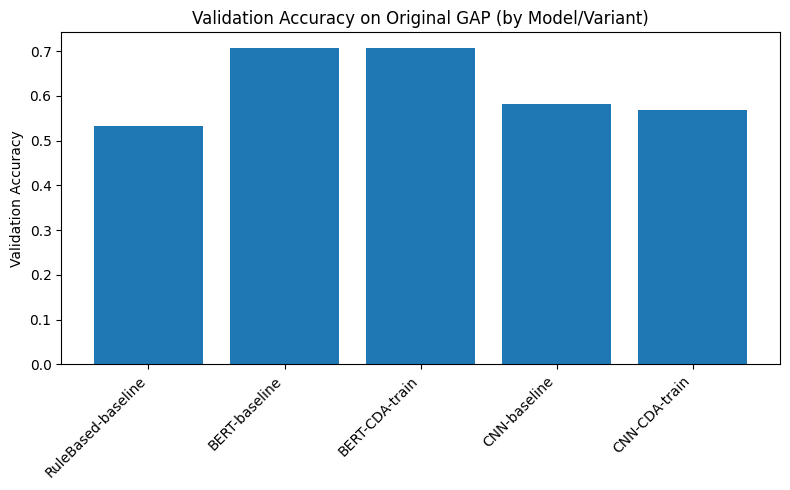

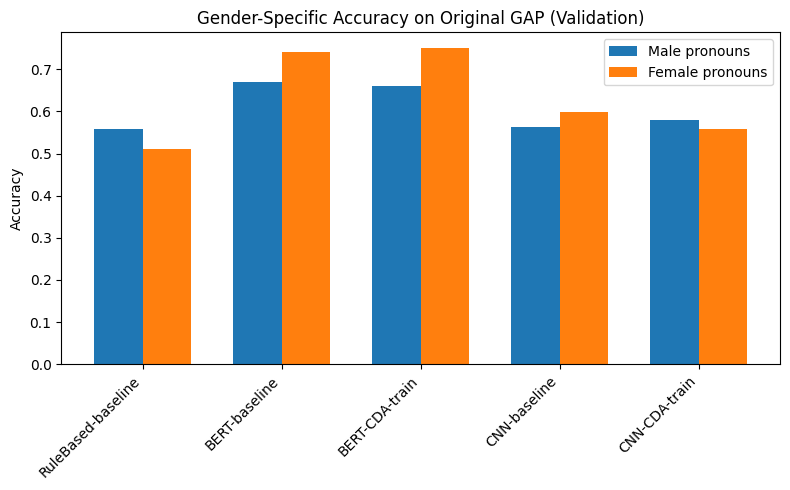

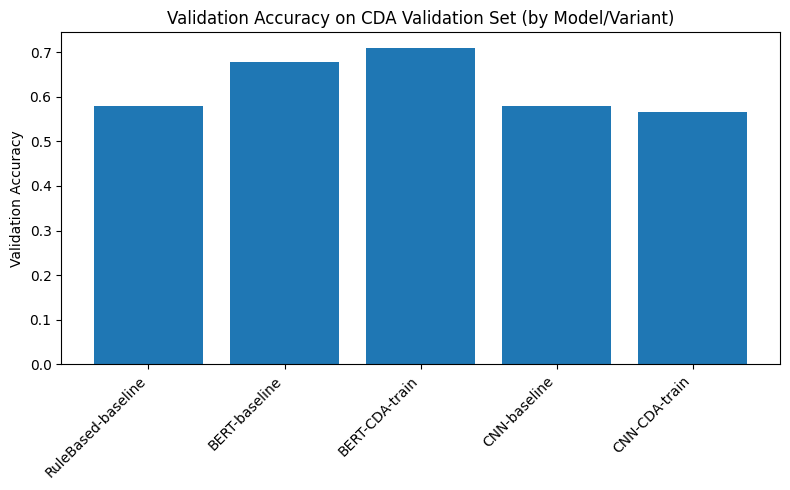

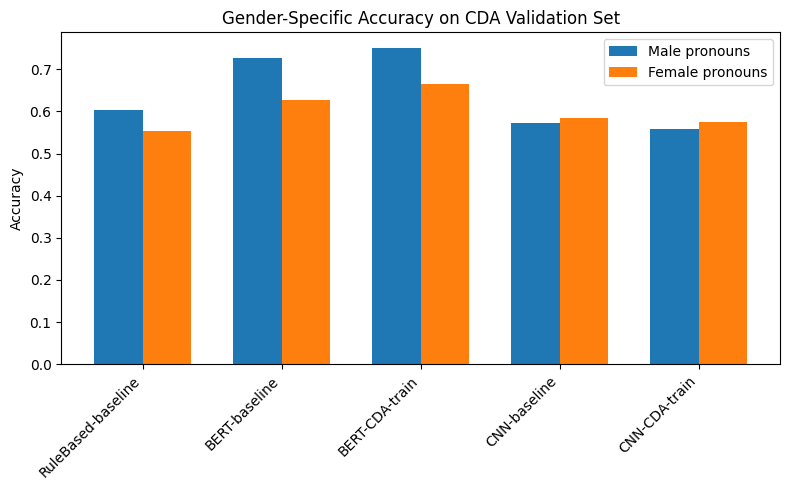

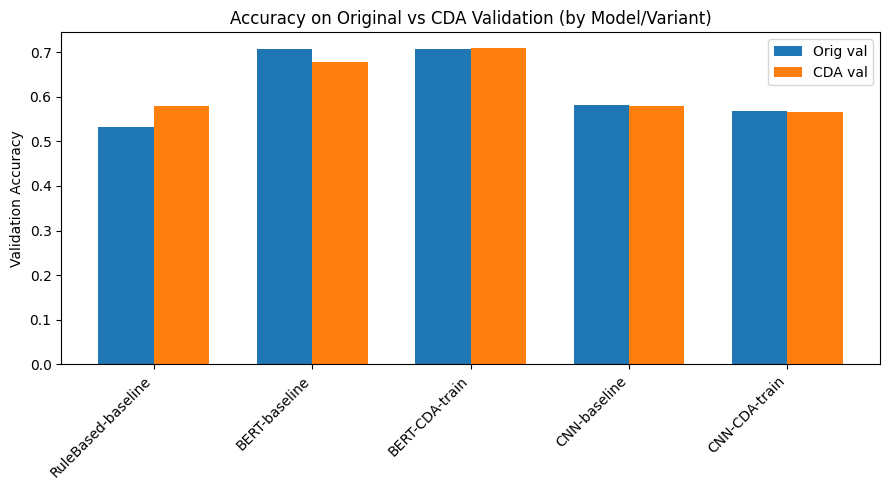

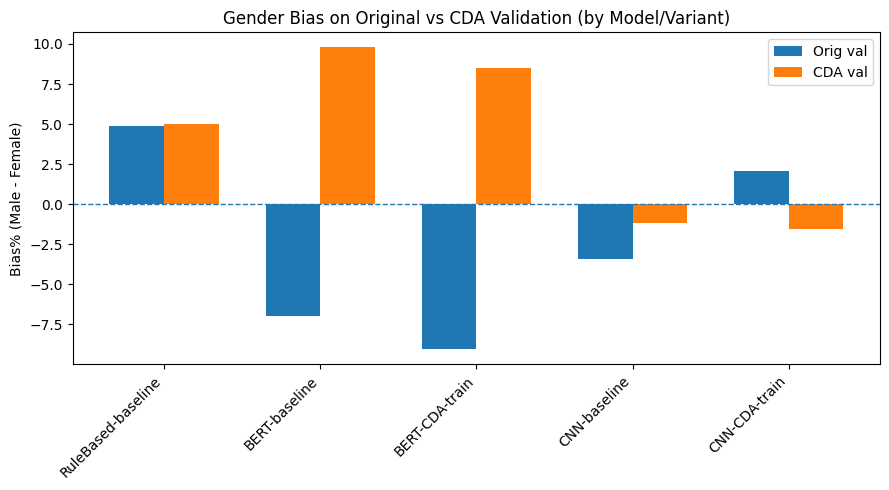


Loading WinoBias from HuggingFace


README.md: 0.00B [00:00, ?B/s]

type1_pro/validation-00000-of-00001.parq(…):   0%|          | 0.00/31.8k [00:00<?, ?B/s]

type1_pro/test-00000-of-00001.parquet:   0%|          | 0.00/33.8k [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/396 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/396 [00:00<?, ? examples/s]

type1_anti/validation-00000-of-00001.par(…):   0%|          | 0.00/31.6k [00:00<?, ?B/s]

type1_anti/test-00000-of-00001.parquet:   0%|          | 0.00/33.8k [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/396 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/396 [00:00<?, ? examples/s]

type2_pro/validation-00000-of-00001.parq(…):   0%|          | 0.00/31.1k [00:00<?, ?B/s]

type2_pro/test-00000-of-00001.parquet:   0%|          | 0.00/31.4k [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/396 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/396 [00:00<?, ? examples/s]

type2_anti/validation-00000-of-00001.par(…):   0%|          | 0.00/31.0k [00:00<?, ?B/s]

type2_anti/test-00000-of-00001.parquet:   0%|          | 0.00/31.5k [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/396 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/396 [00:00<?, ? examples/s]

WinoBias Type 1 examples: 792
WinoBias Type 2 examples: 792

Running WinoBias evaluation for all models

WINOBIAS EVALUATION FOR: Rule-Based

--- TYPE 1 ---
Accuracy:             0.5934
F1 Score:             0.7448
Male Acc:             0.0800
Female Acc:           0.9000
Gender Bias (Male-F): -82.0000
Pro-Stereo Acc:       0.5985
Anti-Stereo Acc:      0.5884
Stereotype Bias:      +0.0101

--- TYPE 2 ---
Accuracy:             0.6035
F1 Score:             0.7528
Male Acc:             0.0000
Female Acc:           0.8333
Gender Bias (Male-F): -83.3333
Pro-Stereo Acc:       0.6010
Anti-Stereo Acc:      0.6061
Stereotype Bias:      -0.0051

WINOBIAS EVALUATION FOR: BERT Base

--- TYPE 1 ---
Accuracy:             0.9912
F1 Score:             0.9956
Male Acc:             0.9800
Female Acc:           0.9900
Gender Bias (Male-F): -1.0000
Pro-Stereo Acc:       0.9899
Anti-Stereo Acc:      0.9924
Stereotype Bias:      -0.0025

--- TYPE 2 ---
Accuracy:             1.0000
F1 Score:             1.00

In [13]:


# ============================================================
# RUN MAIN + WINOBIAS INTEGRATION
# ============================================================

# 1) Run the GAP pipeline and train models
main()

# 2) Load WinoBias from HuggingFace and convert to GAP-style examples

print("\n" + "=" * 70)
print("Loading WinoBias from HuggingFace")
print("=" * 70)

def load_winobias_split(config_name: str, stereo_label: str, type_id: int) -> List[Dict[str, Any]]:
    """
    Load a WinoBias split from HuggingFace (uclanlp/wino_bias) and convert to
    GAP-style examples compatible with predict_batch().
    """
    ds = load_dataset("uclanlp/wino_bias", config_name)
    examples = []

    for row in ds["test"]:
        tokens = row["tokens"]
        text = " ".join(tokens)

        # WinoBias schema: NP1 (occupation A) at tokens[1],
        # NP2 (occupation B) at tokens[4], pronoun at tokens[6]
        A = tokens[1]
        B = tokens[4]
        pron = tokens[6]

        clusters = row["coreference_clusters"]
        # cluster[0] = NP1 cluster, cluster[2] = pronoun cluster
        label = 0 if clusters[0] == clusters[2] else 1

        examples.append({
            "text": text,
            "A": A,
            "B": B,
            "pron": pron,
            "label": label,
            "type": type_id,
            "stereo": stereo_label,
            "A_offset": text.lower().find(A.lower()),
            "B_offset": text.lower().find(B.lower()),
            "pron_offset": text.lower().find(pron.lower()),
        })

    return examples

wb1_pro  = load_winobias_split("type1_pro",  "pro",  1)
wb1_anti = load_winobias_split("type1_anti", "anti", 1)
wb2_pro  = load_winobias_split("type2_pro",  "pro",  2)
wb2_anti = load_winobias_split("type2_anti", "anti", 2)

wb1_examples = wb1_pro + wb1_anti
wb2_examples = wb2_pro + wb2_anti

print(f"WinoBias Type 1 examples: {len(wb1_examples)}")
print(f"WinoBias Type 2 examples: {len(wb2_examples)}")


# 3) Pro vs Anti stereotype bias on WinoBias

def evaluate_winobias_bias(model: BaseCorefModel, examples: List[Dict[str, Any]]) -> Tuple[float, float, float]:
    pro_preds, pro_labels = [], []
    anti_preds, anti_labels = [], []

    for ex in examples:
        pred = model.predict_batch([ex])[0]
        lab = ex["label"]
        if ex["stereo"] == "pro":
            pro_preds.append(pred)
            pro_labels.append(lab)
        else:
            anti_preds.append(pred)
            anti_labels.append(lab)

    def safe_acc(preds, labels):
        if not labels:
            return 0.0
        return acc_metric.compute(predictions=preds, references=labels)["accuracy"]

    pro_acc = safe_acc(pro_preds, pro_labels)
    anti_acc = safe_acc(anti_preds, anti_labels)
    bias = pro_acc - anti_acc
    return pro_acc, anti_acc, bias


def run_winobias(model: BaseCorefModel, name: str):
    print("\n" + "=" * 80)
    print(f"WINOBIAS EVALUATION FOR: {name}")
    print("=" * 80)

    for ex_list, title in [(wb1_examples, "TYPE 1"), (wb2_examples, "TYPE 2")]:
        print(f"\n--- {title} ---")
        acc, f1 = evaluate_model(model, ex_list)
        male_acc, female_acc, gender_bias = compute_gender_bias(model, ex_list)
        pro_acc, anti_acc, stereo_bias = evaluate_winobias_bias(model, ex_list)

        print(f"Accuracy:             {acc:.4f}")
        print(f"F1 Score:             {f1:.4f}")
        print(f"Male Acc:             {male_acc:.4f}")
        print(f"Female Acc:           {female_acc:.4f}")
        print(f"Gender Bias (Male-F): {gender_bias:+.4f}")
        print(f"Pro-Stereo Acc:       {pro_acc:.4f}")
        print(f"Anti-Stereo Acc:      {anti_acc:.4f}")
        print(f"Stereotype Bias:      {stereo_bias:+.4f}")


print("\n" + "=" * 70)
print("Running WinoBias evaluation for all models")
print("=" * 70)

run_winobias(rb_model,   "Rule-Based")
run_winobias(bert_base,  "BERT Base")
run_winobias(bert_cda,   "BERT + CDA")

run_winobias(cnn_base, "CNN Base")
run_winobias(cnn_cda,  "CNN + CDA")


print("\nAll evaluations completed.")
